# What's about?
### This script gets 2D plots with domain "day vs time" by using s4 values from many days for a single PRN 

In [1]:
import septentrio_tools as st
import pandas as pd
import numpy as np
import datetime
import time 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob 

In [2]:
start = time.time()

In [3]:
def process_df(input_file):
    h = st.ProcessISMR()
    # Read and normalize 
    h.read_file(input_file)
    h.normalize_df()
    # Rename the Elev column
    columnas = ["Elev", "S4_sig1", "S4_sig1_corr", "S4_sig2", "S4_sig2_corr", "S4_sig3", "S4_sig3_corr"]
    h.rename_column(5, columnas[0])
    # Rename the s4 columns
    h.rename_column(7, columnas[1])
    h.rename_column(8, columnas[2])
    h.rename_column(32, columnas[3])
    h.rename_column(33, columnas[4])
    h.rename_column(46, columnas[5])
    h.rename_column(47, columnas[6])
    # Extract certain columns 
    h.extract_columns(cols=columnas)
    # Convert to float 
    h.convert2float(cols=columnas)
    # Assign the df 
    df2 = h.df
    # Calculate the corrected S4
    def get_correctedS4(row):
        s4 = row[0]
        correction= row[1]

        # Treat nan numbers 
        if pd.isnull(s4) or pd.isnull(correction):
            return np.nan
        else:
            # Calculate the corrected S4
            x = s4**2-correction**2
            if x>0:
                return x**0.5
            else:
                return 0    

    for i in range(3):        
        # calculate
        df2[f"S4_sig{i+1}"] = df2[[f"S4_sig{i+1}",f"S4_sig{i+1}_corr"]].apply(get_correctedS4, axis=1)
        # delete
        del df2[f"S4_sig{i+1}_corr"]
        
    return df2  

In [4]:
path_src = "/home/luis/Desktop/Proyects_Files/LISN/GPSs/Tareas/Plot_s4_2D/Input_data/Data_set2/"

In [5]:
list_files = glob.glob(path_src + "*.ismr")
list_files = sorted(list_files, key=lambda x: (x[-8:-6], x[-17:-9])) # sort by year first, then by doy  
j = 0
if len(list_files) > 0:
    for file in list_files:
        df1 = process_df(file)
        if j == 0:
            df2 = df1
        else:
            # Merge dfs
            df2 = df2.append(other=df1)
        j += 1       
df3 = df2
df3.head()

,PRN,Elev,S4_sig1,S4_sig2,S4_sig3
DateTime,,,,,
2020-09-26 00:01:00,G10,72.0,0.000000,0.021633,0.0
2020-09-26 00:01:00,G16,49.0,0.064062,NaN,NaN
2020-09-26 00:01:00,G20,40.0,0.098590,NaN,NaN
2020-09-26 00:01:00,G21,33.0,0.083720,NaN,NaN
2020-09-26 00:01:00,G26,83.0,0.000000,0.000000,0.0


## Plot for an unique PRN

### 1. Extract values for a unique PRN / const / freq 

In [6]:
m = st.PlotsISMR(dataframe=df3, ismr_file_name="ljic2800.20_.ismr")

In [7]:
m.extract_prns(const='G', freq='S4_sig1')

['G1',
 'G2',
 'G3',
 'G4',
 'G5',
 'G6',
 'G7',
 'G8',
 'G9',
 'G10',
 'G11',
 'G12',
 'G13',
 'G15',
 'G16',
 'G17',
 'G18',
 'G19',
 'G20',
 'G21',
 'G22',
 'G24',
 'G25',
 'G26',
 'G27',
 'G28',
 'G29',
 'G30',
 'G31',
 'G32']

In [8]:
prn1 = 'G2'

In [9]:
s1 = m.get_variable(prn=prn1, var='S4_sig1')
print(s1.head())
s1.tail()

DateTime
2020-09-26 09:03:00    0.075472
2020-09-26 09:04:00    0.253614
2020-09-26 09:05:00    0.094805
2020-09-26 09:06:00    0.067171
2020-09-26 09:07:00    0.201333
Name: S4_sig1, dtype: float64


DateTime
2020-09-27 19:13:00    0.071386
2020-09-27 19:14:00    0.227982
2020-09-27 19:15:00    0.385123
2020-09-27 19:16:00    0.455543
2020-09-27 19:17:00    0.382304
Name: S4_sig1, dtype: float64

In [10]:
s1.describe()

count    1148.000000
mean        0.068561
std         0.051331
min         0.000000
25%         0.037590
50%         0.060609
75%         0.087156
max         0.455543
Name: S4_sig1, dtype: float64

In [11]:
s1.to_csv("series1")

### 2. Reassigning s4 values based on time values

In [12]:
# Complete extreme values for index variable (datetime)
# -> Lower value of range
val1 = s1.index[0]
val1_comp = datetime.datetime(val1.year, val1.month, val1.day, 0, 0)
if val1 != val1_comp:
    s_aux1 = pd.concat([pd.Series([np.nan]), s1])
    s_aux1 = s_aux1.rename({0:val1_comp})

# -> Upper value of range
val2 = s1.index[-1]
val2_comp = datetime.datetime(val2.year, val2.month, val2.day, 23, 59) + datetime.timedelta(minutes=1)
if val2 != val2_comp:
    s_aux2 = pd.concat([s_aux1, pd.Series([np.nan])])
    s_aux2 = s_aux2.rename({0:val2_comp})

print(s_aux2.head())
s_aux2.tail()

2020-09-26 00:00:00         NaN
2020-09-26 09:03:00    0.075472
2020-09-26 09:04:00    0.253614
2020-09-26 09:05:00    0.094805
2020-09-26 09:06:00    0.067171
dtype: float64


2020-09-27 19:14:00    0.227982
2020-09-27 19:15:00    0.385123
2020-09-27 19:16:00    0.455543
2020-09-27 19:17:00    0.382304
2020-09-28 00:00:00         NaN
dtype: float64

In [13]:
# Resampling 
s2 = s_aux2.resample("T").asfreq() # Each minute 
s2.to_csv("series2")
print(s2.head())
print(s2.tail())

2020-09-26 00:00:00   NaN
2020-09-26 00:01:00   NaN
2020-09-26 00:02:00   NaN
2020-09-26 00:03:00   NaN
2020-09-26 00:04:00   NaN
Freq: T, dtype: float64
2020-09-27 23:56:00   NaN
2020-09-27 23:57:00   NaN
2020-09-27 23:58:00   NaN
2020-09-27 23:59:00   NaN
2020-09-28 00:00:00   NaN
Freq: T, dtype: float64


### 3. Create the s4 2D array

In [22]:
fechas = np.unique(s2.index.date)
fechas

array([datetime.date(2020, 9, 26), datetime.date(2020, 9, 27),
       datetime.date(2020, 9, 28)], dtype=object)

In [14]:
fechas = np.unique(s2.index.date)

j=0
for fecha in fechas:
    ind = fecha.strftime("%Y-%m-%d")
    serie = s2.loc[ind]
    values = serie.values
    if len(values) > 1:
        if j==0: 
            s4_array = [values]  
        else:
            s4_array = np.append(s4_array, [values], axis=0)
    j += 1

s4_array = s4_array.T
print(s4_array)
s4_array.shape

[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]


(1440, 2)

### 4. Define x and y range values

In [15]:
# Define x range values 
x_lims=[fechas[0], fechas[-1]]
x_lims

[datetime.date(2020, 9, 26), datetime.date(2020, 9, 28)]

In [16]:
# Define y range values 
yo = datetime.datetime(fechas[0].year, fechas[0].month, fechas[0].day, 0, 0)
y_lims= [yo, yo + datetime.timedelta(days=1)]
y_lims

[datetime.datetime(2020, 9, 26, 0, 0), datetime.datetime(2020, 9, 27, 0, 0)]

### 5. Change x,y datetime to numeric values

In [17]:
x_lims = mdates.date2num(x_lims)
x_lims

array([737694., 737696.])

In [18]:
y_lims = mdates.date2num(y_lims)
y_lims

array([737694., 737695.])

### 6. Plot s4 values

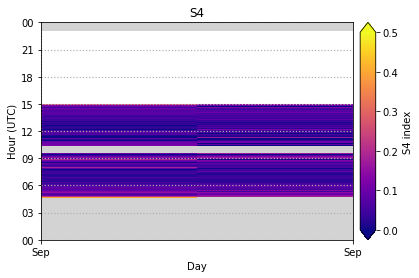

In [19]:
fig, ax = plt.subplots()

# Strip morning/night
fecha_morning_first = yo + pd.DateOffset(hours=11) 
fecha_morning_first = fecha_morning_first.to_pydatetime()
fecha_morning_last = yo + pd.DateOffset(hours=23)
fecha_morning_last = fecha_morning_last.to_pydatetime()
#ax.set_facecolor(color="lightgrey")
#ax.axhspan(fecha_morning_first, fecha_morning_last, color="white") # strip morning/night

# Plot
cmap = "plasma"
im = ax.imshow(s4_array, cmap=cmap, extent=[x_lims[0], x_lims[1],  y_lims[0], y_lims[1]], aspect = 'auto', vmin=0, vmax=0.5)
ax.set(xlabel="Day", ylabel="Hour (UTC)", title="S4")
#ax.grid()
ax.xaxis_date()
ax.yaxis_date()

#ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) # Every day 
ax.xaxis.set_major_locator(mdates.DayLocator(1)) # First day every month 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))#('%b'))

date_format2 = mdates.DateFormatter('%H')
ax.yaxis.set_major_formatter(date_format2)
#fig.autofmt_xdate()

ax.set_facecolor(color="lightgrey")
ax.axhspan(fecha_morning_first, fecha_morning_last, color="white", zorder=0) # strip morning/night, and send to back 

# Grid
ax.grid(which='major', axis='both', ls=':', linewidth=1.2)
#ax.grid(which='minor', axis='both', ls=':', alpha=0.5)

# Legend 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1) # pad es el espaciado con la grafica principal
plt.colorbar(im,cax=cax,label='S4 index',extend='both')
    
plt.show()

In [20]:
end = time.time()
print(f"Executing time: {end - start}s")

Executing time: 20.523109436035156s


In [21]:
437/60

7.283333333333333